In [38]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm

year = 365 * 24 * 3600.0
cm_per_yr = 0.01 / year

## The viscous corner flow model

(Turcotte & Schubert, geodynamics, 3rd edition, ch 6.11)

In a vicous corner flow model, we consider the oceanic lithosphere as bending in a continuous manner as it is subducted at an ocean trench. 
The gravitational body force on the descending lithosphere is directed vertically downward, and pressure forces (aka, dynamic pressure) due to the induced flows in the mantle will balance the gravitational body forces.
First, the model domain is divided into the Arc corner and the Oceanic corner:

![](./figure_6_17.png)

In this analytical approach, the flow field in both the Arc corner and the Oceanic corner is solved, then the pressure forces acting on the descending litho-sphere can be calculated using these solutions.

### Define the class for solving viscous corner flow model

For the general solution, it follows from:

$$ u = -B - D arctan\left(\frac{y}{x}\right) + \left(Cx + Dy\right)\left(\frac{-x}{x^2 + y^2}\right) $$
$$ v = A + Carctan\left(\frac{y}{x}\right) + \left(Cx + Dy\right)\left(\frac{-y}{x^2 + y^2}\right) $$
$$ P = \frac{-2 \mu \left(Cx + Dy\right)}{x^2 + y^2} $$

For the arc corner:
$$ C = \frac{\theta_d sin \theta_d}{\theta_d^2 - {sin \theta_d}^2} $$
$$ D = \frac{sin \theta_d - \theta_d cos \theta_d}{\theta_d^2 - {sin \theta_d}^2} $$
$$ A = 0 $$
$$ B = -C $$

For the oceanic corner:
$$ C = \frac{{sin \theta_d}^2 - \left(\pi - \theta_d \right)sin \theta_d}{\left(\pi - \theta_d \right)^2 - {sin \theta_d}^2}$$
$$ D = \frac{\left(\pi - \theta_d \right)\left(cos \theta_d - 1\right) + sin \theta_d - cos \theta_d sin \theta_d}{\left(\pi - \theta_d \right)^2 - {sin \theta_d}^2}$$
$$ A = -C \pi $$
$$ B = - \left(U + D \pi + C \right)


In [16]:
# Define the class for solving the problem
def GetDomain(x, y, theta_d):
    '''
    Get which domain a point belongs to
    Inputs:
        x
        y
        theta_d - dip angle
    return:
        pos - 0 (in the arc corner) or 1 (in the oceanic corner)
    '''
    theta = np.arctan2(y, x)
    pos = 0
    if theta > theta_d:
        pos = 1
    return pos


def GeneralSolution(x, y, A, B, C, D):
    '''
    Return the value of velocities from the general solution of the viscous corner flow model
    Inputs:
        x, y
        A, B, C, D - coefficents in the general solution
    Return:
        u - velocity along x
        v - velocity along y
    '''
    u = -B - D * np.arctan2(y, x) + (C*x + D*y)*(-x / (x**2.0 + y**2.0))
    v = A + C * np.arctan2(y, x) + (C*x + D*y)*(-y / (x**2.0 + y**2.0))
    return u, v


def PressureSolution(x, y, mu, C, D):
    '''
    Return the value of pressure from the general solution of the viscous corner flow model
    Inputs:
        x, y
        mu - viscosity
        C, D - coefficents in the general solution
    Return:
        P - pressure
    '''
    P = -2 * mu * (C * x + D * y) / (x**2.0 + y**2.0)
    return P



class VISCOUS_CORNER_FLOW():

    def __init__(self):
        '''
        Initiation
        '''
        self.theta_d = 0.0  # dip angle
        self.U = 0.0  # subducting velocity
        self.Aoc = 0.0  # coefficents for solution in the oceanic corner
        self.Boc = 0.0
        self.Coc = 0.0
        self.Doc = 0.0
        self.Aac = 0.0  # coefficents for solution in the arc corner
        self.Bac = 0.0
        self.Cac = 0.0
        self.Dac = 0.0
        self.oceanic_corner_solved = False
        self.arc_corner_solved = False
    
    def Reset(self):
        '''
        reset all the values
        '''
        self.__init__()

    def PrescribeDipVelocity(self, theta_d, U):
        '''
        Prescribe dip angle and velocity
        '''
        self.theta_d = theta_d
        self.U = U
    
    def PrescribeDomainViscosity(self, mu):
        '''
        Prescribe viscosity to the whole domain
        '''
        self.mu = mu

    def SolveOceanicCorner(self):
        '''
        solve coefficents in the oceanic corner
        '''
        theta_d = self.theta_d
        denominator = (np.pi - theta_d)**2.0 - np.sin(theta_d)**2.0
        dividend_C = np.sin(theta_d)**2.0 - (np.pi - theta_d) * np.sin(theta_d)
        dividend_D = (np.pi - theta_d) * (np.cos(theta_d) - 1.0) + np.sin(theta_d)\
        - np.cos(theta_d) * np.sin(theta_d)
        self.Coc = dividend_C / denominator * self.U
        self.Doc = dividend_D / denominator * self.U
        self.Aoc = - self.Coc * np.pi
        self.Boc =  - (self.U + self.Doc * np.pi + self.Coc)
        self.oceanic_corner_solved = True
    
    def SolveArcCorner(self):
        '''
        solve coeffients in the arc corner
        '''
        theta_d = self.theta_d
        denominator = theta_d**2.0 - np.sin(theta_d)**2.0
        dividend_C = theta_d * np.sin(theta_d)
        dividend_D = np.sin(theta_d) - theta_d * np.cos(theta_d)
        self.Cac = dividend_C / denominator * self.U
        self.Dac = dividend_D / denominator * self.U
        self.Aac = 0.0 
        self.Bac = -self.Cac
        self.arc_corner_solved = True
    
    def ProblemSolved(self):
        '''
        Return whether the problem is solved
        '''
        solved = self.oceanic_corner_solved and self.arc_corner_solved\
        and self.U > 0.0 and self.mu > 0.0
        return solved
    
    def GetFlowVelocity(self, x, y):
        '''
        return flow velocity in a viscous corner flow model
        Inputs:
            x, y
            theta_d - the dip angle
        Returns:
            u - velocity along x
            v - velocity along y
            pos - 0 (in the arc corner) or 1 (in the oceanic corner)
        '''
        assert(self.ProblemSolved())  # assert solution is derived
        theta = np.arctan2(y, x)
        pos = GetDomain(x, y, self.theta_d)
        if pos == 0:
            # use the coefficients for the arc corner
            u, v = GeneralSolution(x, y, self.Aac, self.Bac, self.Cac, self.Dac)
        elif pos == 1:
            # use the coefficients for the oceanic corner
            u, v = GeneralSolution(x, y, self.Aoc, self.Boc, self.Coc, self.Doc)
        else:
            raise ValueError("A wrong value for \'pos\'")
        return u, v, pos
    
    def GetPressure(self, x, y):
        '''
        return flow velocity in a viscous corner flow model
        Inputs:
            x, y
            theta_d - the dip angle
        Returns:
            u - velocity along x
            v - velocity along y
            pos - 0 (in the arc corner) or 1 (in the oceanic corner)
        '''
        assert(self.ProblemSolved())  # assert solution is derived
        theta = np.arctan2(y, x)
        pos = GetDomain(x, y, self.theta_d)
        if pos == 0:
            P = PressureSolution(x, y, self.mu, self.Cac, self.Dac)
        elif pos == 1:
            P = PressureSolution(x, y, self.mu, self.Coc, self.Doc)
        else:
            raise ValueError("A wrong value for \'pos\'")
        return P, pos
    
    def ExportCD(self):
        '''
        export C and D in the coefficients
        '''
        assert(self.ProblemSolved())  # assert solution is derived
        return self.Cac, self.Dac, self.Coc, self.Doc
    


### Generate a corner flow for a 45-degree dipping slab

In [17]:
def SolveArcCorners45(U):
    '''
    Standard solution for a 45 degree arc corner, (6.115) and (6.116)
    '''
    C =  -np.pi * U * 2**0.5 / (2 * (2 - np.pi**2.0 / 4.0))
    D = - U * 2**0.5 * (2- np.pi / 2.0) / (2 - np.pi**2.0/4.0)
    return C, D

def SolveOceanicCorners45(U):
    '''
    Standard solution for a 45 degree oceanic corner, (6.122) and (6.123)
    '''
    C = U / (9 * np.pi**2.0/4 - 2.0) * (2 - 2**0.5 / (1 + 3 * np.pi / 2.0) * (3 * np.pi / 2.0 + 9 * np.pi**2.0 / 4.0))
    D = U / (9 * np.pi**2.0/4 - 2.0) * (2**0.5 * (2 + 3 * np.pi / 2.0) - 2.0 * (1 + 3 * np.pi / 2.0))
    return C, D


def SolvePressureArcCorner(r, mu, U):
    '''
    Standard solution for a 45 degree arc corner of pressure, (6.117)
    Note that this solution is on the line of x = y
    '''
    P = 4 * mu * U / (2 - np.pi**2.0/4.0) / r
    return P


def SolvePressureOceanicCorner(r, mu, U):
    '''
    Standard solution for a 45 degree arc corner of pressure, (6.124)
    Note that this solution is on the line of x = y
    '''
    P =  mu * U / r * (3 * np.pi * 2**0.5 - 4.0) / (9 * np.pi**2.0 / 4.0 - 2.0)
    return P


def Test45():
    '''
    Run the test for a 45-deg dipping slab
    '''
    # variable values for the model
    theta_d = np.pi / 4.0
    mu = 1e21
    U0 =  1 * cm_per_yr
    # coordinate values
    x = np.linspace(-1000e3, 1000e3, 200)
    y = np.linspace(0, 1000e3, 150)
    xx, yy = np.meshgrid(x, y)
    # initiate arrays to save values
    uu = np.zeros(xx.shape)
    vv = np.zeros(xx.shape)
    PP = np.zeros(xx.shape)
    # solve the problem
    VCF = VISCOUS_CORNER_FLOW()
    VCF.PrescribeDipVelocity(theta_d, U0)
    VCF.PrescribeDomainViscosity(mu)
    VCF.SolveArcCorner()
    VCF.SolveOceanicCorner()
    # check the solution
    Cac, Dac = SolveArcCorners45(U0)
    Coc, Doc = SolveOceanicCorners45(U0)
    x0, y0 = 50.001e3, 50e3  # a point in the arc corner
    x1, y1 = 50e3, 50.001e3  # a point in the oceanic corner
    r = 50*2**0.5*1e3
    Pac_std = SolvePressureArcCorner(r, mu, U0)
    Poc_std = SolvePressureOceanicCorner(r, mu, U0)
    Pac, _ = VCF.GetPressure(x0, y0)
    Poc, _ = VCF.GetPressure(x1, y1)
    print("Standard value for the arc corner: C = %.4e, D = %4e" % (Cac, Dac))
    print("Analytic value for the arc corner: C = %.4e, D = %4e" % (VCF.Cac, VCF.Dac))
    print("Standard value for the oceanic corner: C = %.4e, D = %4e" % (Coc, Doc))
    print("Analytic value for the oceanic corner: C = %.4e, D = %4e" % (VCF.Coc, VCF.Doc))
    print("Standard value for P in the arc corner: P = %.4e" % Pac_std)
    print("Analytic value for P in the arc corner: P = %.4e" % Pac)
    print("Standard value for P in the oceanic corner: P = %.4e" % Poc_std)
    print("Analytic value for P in the oceanic corner: P = %.4e" % Poc)
    # get the field components
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            u, v, _ = VCF.GetFlowVelocity(xx[i, j], yy[i, j])
            P, _ = VCF.GetPressure(xx[i, j], yy[i, j])
            uu[i, j] = u
            vv[i, j] = v
            PP[i, j] = P
    vv_mag = (uu**2.0 + vv**2.0) ** 0.5
    return xx, yy, uu, vv, vv_mag, PP

xx, yy, uu, vv, vv_mag, PP = Test45()  # run the test for a 45-dipping slab

Standard value for the arc corner: C = 1.5071e-09, D = 4.117960e-10
Analytic value for the arc corner: C = 1.5071e-09, D = 4.117960e-10
Standard value for the oceanic corner: C = -7.3196e-11, D = -3.031887e-11
Analytic value for the oceanic corner: C = -7.3196e-11, D = -3.031887e-11
Standard value for P in the arc corner: P = -3.8378e+07
Analytic value for P in the arc corner: P = -3.8378e+07
Standard value for P in the oceanic corner: P = 2.0703e+06
Analytic value for P in the oceanic corner: P = 2.0703e+06


### Create a function to plot

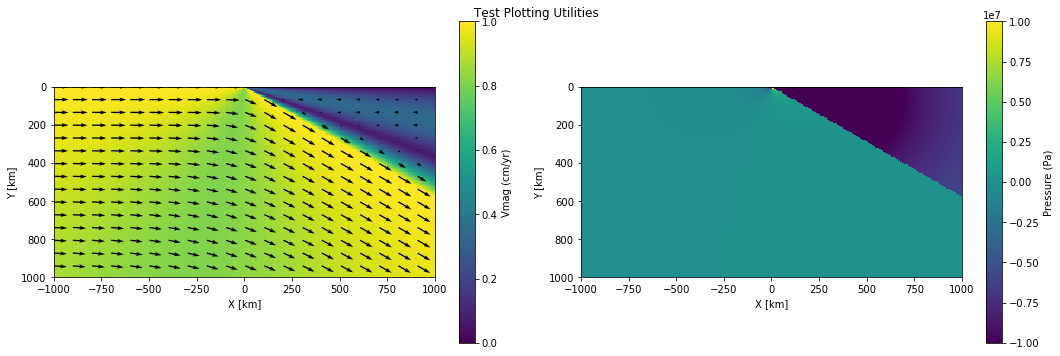

In [36]:
def PlotFieldResults(xx, yy, uu, vv, vv_mag, PP, theta_d, _figsize, _title):
    '''
    Plot field vectors from the viscous corner flow model
    xx, yy, uu, vv, vv_mag, PP: solutions from a vicous corner flow model
    theta_d: the dip angle of subduction
    '''
    # construct a dipping line
    dip_xs = np.linspace(0, np.linalg.norm(xx, np.inf), 100)
    dip_ys = dip_xs * np.tan(theta_d)
    # Plot the solution
    fig = plt.figure(tight_layout=True, figsize=_figsize)
    gs = gridspec.GridSpec(1, 2)
    ax = fig.add_subplot(gs[0, 0])  # velocity magnitude and velocity direction
    h = ax.pcolormesh(xx/1e3, yy/1e3, vv_mag / cm_per_yr)
    skip = (slice(None, None, 10), slice(None, None, 10))   # resample the quiver, add in a stride
    ax.quiver(xx[skip]/1e3, yy[skip]/1e3, uu[skip]/cm_per_yr, vv[skip]/cm_per_yr, angles='xy')
    # ax.scatter(dip_xs, dip_ys)  # plot the slab surface
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X [km]')
    ax.set_ylabel('Y [km]')
    fig.colorbar(h, ax=ax, label='Vmag (cm/yr)')
    ax = fig.add_subplot(gs[0, 1])  # pressure
    h = ax.pcolormesh(xx/1e3, yy/1e3, PP, vmin=-1e7, vmax=1e7)
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X [km]')
    ax.set_ylabel('Y [km]')
    fig.colorbar(h, ax=ax, label='Pressure (Pa)')
    fig.suptitle(_title)


def PlotPressureProfile(depths, Ps, _figsize, _title):
    '''
    Plot the pressure profile along the surface and bottom of a slab
    '''
    Pmax = np.abs(np.interp(50e3, depths, Ps[:, 0]))  # figure out a limit for the plot
    fig = plt.figure(tight_layout=True, figsize=_figsize)
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])  # velocity magnitude and velocity direction
    ax.semilogx(-Ps[:, 0], depths/1e3, "b--", label="Arc corner")
    ax.semilogx(Ps[:, 1], depths/1e3, "c--", label="Oceanic corner")
    ax.semilogx(Ps[:, 1] - Ps[:, 0], depths/1e3, "r", label="Total support (Oceanic - Arc)")
    ax.invert_yaxis()
    ax.set_xlim([0, Pmax])
    ax.set_xlabel('Pressure [Pa]')
    ax.set_ylabel('Y [km]')
    ax.legend()
    fig.suptitle(_title)


PlotFieldResults(xx, yy, uu, vv, vv_mag, PP, np.pi/4.0, (15, 5), "Test Plotting Utilities")  # test

### Solver fo correponding dipping angle with force balance (unfinished).

One explanation for why the lithosphere descends at an angle other than 90 deg is that pressure forces due to the induced flows in the mantle balance the gravitational body forces.

From the example showing a 45-degree dipping subduction, the pressure forces are due to the mantle flow induced by the motion of the descending lithosphere. They are flow pressures relative to the hydrostatic pressure. 
The dip of a subducting lithosphere is thus a consequence of the balance between the gravitational torque and the lifting pressure torque.

![Torque balance](./torque_balance.png)

A torque balance could be derived with:

$$\int_{r=0}^l \left[ P_{OC}\left(r\right)-P_{AC}\left(r\right) \right]rdr = \int_{r=0}^l \Delta \rho g d_{plate} x dr$$

In this equation, $P_{AC}$ and $P_{OC}$ are pressures on both sides of the slab. $d_{plate}$ is the thickness of the plate. We are assuming the plate is a constant thickness with excessive density $\Delta \rho$ and length l.

The previous integration could be solved to:

$$ tan \theta_d = \frac{\Delta \rho g d l - 4 \mu \left(C_{AC}\left(\theta_d\right) - C_{OC}\left(\theta_d\right)\right)}{4 \mu \left(D_{AC}\left(\theta_d\right) - D_{OC}\left(\theta_d\right)\right)}$$

A simple way to solve is to do a search in the range 0 - 90 degree and see where the mismatch between the two sides is the smallest.

Note from running the test case, it seems this might have 2 solutions: one with smaller dipping angle and one with very big dipping angle.
If the value of viscosity is not suitable, it might be there is not solution, as the first term on the right might be too big when mu is small.

In [19]:
# solve for corresponding theta_d from slab length, velocity, difference in density and thickness
def SolveDippingAngle(gforce, mu, U0, **kwargs):
    '''
    Inputs:
        gforce: multiplification of drho, g, d and l
        mu and U: notice that an entry into the equation
         is actually the multiplication of the two
    Return:
        theta_d: the dipping angle
    '''
    dbg = kwargs.get('dbg', 0) 
    VCF = VISCOUS_CORNER_FLOW()
    theta_ds = np.linspace(0.1, np.pi*0.499, 180)
    mismatches = np.zeros(theta_ds.shape)
    i = 0
    for theta_d in theta_ds:
        VCF.PrescribeDipVelocity(theta_d, U0)
        VCF.PrescribeDomainViscosity(mu)
        VCF.SolveArcCorner()
        VCF.SolveOceanicCorner()
        # check the solution
        Cac, Dac, Coc, Doc = VCF.ExportCD()
        right = (gforce - 4 * mu*(Cac - Coc)) / (4 * mu * (Dac - Doc))
        mismatches[i] = (np.tan(theta_d) - right) / np.tan(theta_d)
        # mismatches[i] = np.tan(theta_d) - right
        i += 1
        VCF.Reset()
    if dbg == 1:
        print("mismatches: ", mismatches)
    i_min_mismatch = np.argmin(np.abs(mismatches))
    theta_min_mismatch = theta_ds[i_min_mismatch]
    return theta_min_mismatch, abs(mismatches[i_min_mismatch])


def TestSolve():
    '''
    A test case for solving the dip angle using torque balance
    '''
    # some values to solve with
    drho = 80
    g = 10.0
    d = 100e3
    l = 300e3
    mu = 1e21
    U0 = 1.0 * cm_per_yr
    theta_d, mismatch = SolveDippingAngle(drho * g * d * l, mu, U0, dbg=1) # call the function to solve
    print("Dipping angle: %.4e, mismatch: %.4e" % (theta_d, mismatch))

# TestSolve() # run the test case

### Some usage of this Utilities - Solve the viscous corner flow for a given dipping angle, viscosity and subducting velocity

Here we also plot the dynamic pressure profile in the arc corner and in the oceanic corner. Note there is a singularity in the corner, where the pressure goes to infinite.

First, a case with 30-degree dipping angle, 1e21 mantle viscosity and 1 cm / yr velocity is solved here.

/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


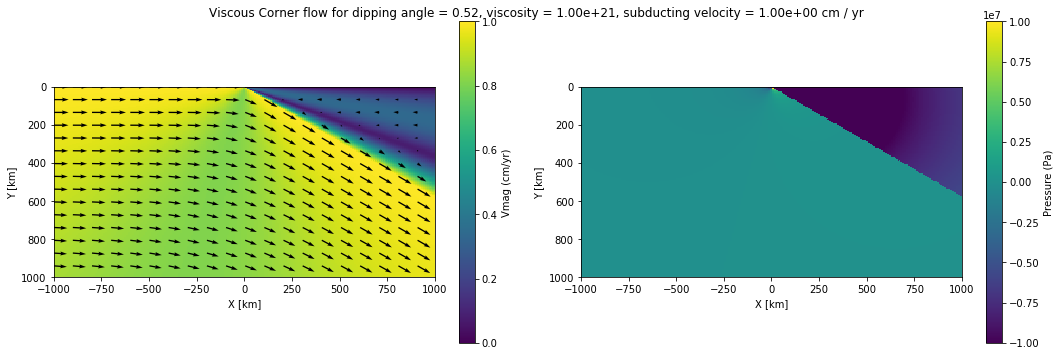

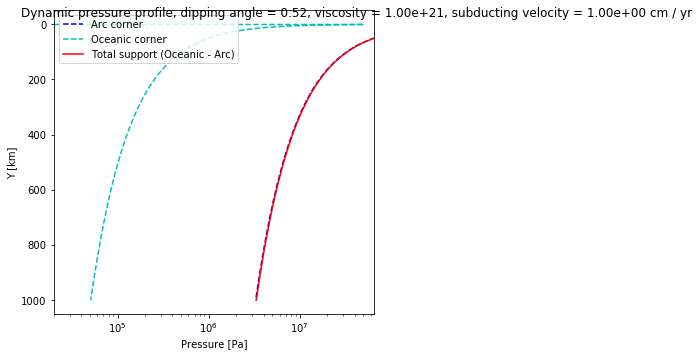

In [37]:
def SolveCornerFlow(theta_d, mu, U0):
    '''
    Solve viscous corner flow
    Inputs:
        theta_d - dipping angle
        mu - viscosity
        U0 - a constant velocity
    '''
    domain_depth = 1e6
    domain_width = 2e6
    # coordinate values
    x = np.linspace(-domain_width/2.0, domain_width/2.0, 200)
    y = np.linspace(0, domain_depth, 150)
    xx, yy = np.meshgrid(x, y)
    # initiate arrays to save values
    uu = np.zeros(xx.shape)
    vv = np.zeros(xx.shape)
    PP = np.zeros(xx.shape)
    # solve the problem
    VCF = VISCOUS_CORNER_FLOW()
    VCF.PrescribeDipVelocity(theta_d, U0)
    VCF.PrescribeDomainViscosity(mu)
    VCF.SolveArcCorner()
    VCF.SolveOceanicCorner()
    # check the solution
    Cac, Dac = SolveArcCorners45(U0)
    Coc, Doc = SolveOceanicCorners45(U0)
    # get the field components
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            u, v, _ = VCF.GetFlowVelocity(xx[i, j], yy[i, j])
            P, _ = VCF.GetPressure(xx[i, j], yy[i, j])
            uu[i, j] = u
            vv[i, j] = v
            PP[i, j] = P
    vv_mag = (uu**2.0 + vv**2.0) ** 0.5
    # get depth profile
    depths = np.linspace(0, domain_depth, 1000)
    Ps = np.zeros((depths.size, 2))
    i = 0
    for depth in depths:
        x_surf = depth / np.tan(theta_d)
        P0, _ = VCF.GetPressure(x_surf+1, depth)  # pressure in the arc corner
        P1, _ = VCF.GetPressure(x_surf-1, depth)  # pressure in the oceanic corner
        Ps[i, 0] = P0 
        Ps[i, 1] = P1 
        i += 1
    return xx, yy, uu, vv, vv_mag, PP, depths, Ps


theta_d = np.pi / 6.0
mu = 1e21
U = 1.0 * cm_per_yr
xx, yy, uu, vv, vv_mag, PP, depths, Ps =  SolveCornerFlow(theta_d, mu, U)
_title = "Viscous Corner flow for dipping angle = %.2f, viscosity = %.2e, subducting velocity = %.2e cm / yr"\
    % (theta_d, mu, U / cm_per_yr)
PlotFieldResults(xx, yy, uu, vv, vv_mag, PP, np.pi/4.0, (15, 5), _title)
_title_p = "Dynamic pressure profile, dipping angle = %.2f,\
 viscosity = %.2e, subducting velocity = %.2e cm / yr" % (theta_d, mu, U / cm_per_yr)
PlotPressureProfile(depths, Ps, (10, 5), _title_p)

Next, plot the profile for a couple of different viscosities that could be applied to the mantle.
In the case, we still take the case of a 30-degree dipping slab

/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


Text(0.5, 0.98, 'Dynamic pressure profile, dipping angle = 0.52')

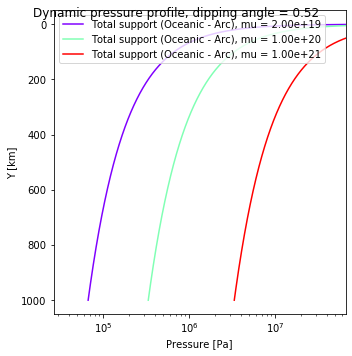

In [41]:
theta_d = np.pi / 6.0
U = 1.0 * cm_per_yr
mus = [2e19, 1e20, 1e21]
length = len(mus)
Pmax = 0.0
fig = plt.figure(tight_layout=True, figsize=(5, 5))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])  # velocity magnitude and velocity direction
normalizer = [float(i)/(length-1) for i in range(length)]
colors = cm.rainbow(normalizer)
i = 0
for mu in mus:
    xx, yy, uu, vv, vv_mag, PP, depths, Ps =  SolveCornerFlow(theta_d, mu, U)
    Pmax = max(Pmax, np.abs(np.interp(50e3, depths, Ps[:, 0])))  # figure out a limit for the plot
    ax.semilogx(Ps[:, 1] - Ps[:, 0], depths/1e3, color=colors[i], label="Total support (Oceanic - Arc), mu = %.2e" % mu)
    i += 1
ax.invert_yaxis()
ax.set_xlim([0, Pmax])
ax.set_xlabel('Pressure [Pa]')
ax.set_ylabel('Y [km]')
ax.legend()
fig.suptitle("Dynamic pressure profile, dipping angle = %.2f" % (theta_d))
fig.tight_layout()